# Theme 2 - Climate Variability, Ocean Circulation, and Ecosystem
## Climate Variability and Ecosystems
OOI Data Labs Education Nuggets

**Objective**: Demonstrate how to download data from multiple instruments on one OOI Global Flanking Mooring using the Machine-to-Machine (M2M) interface, remove outliers, calculate hourly averages, and export the data as a .csv file.

In [1]:
# Notebook Setup
import requests
import os
import re
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 1. Request Data from OOINet

* **Global Station Papa** - CTD and fluorometer data from Flanking Mooring B
    * **CTDs**:
        * Instruments:
            * GP03FLMB-RIM01-02-CTDMOG060 (30m)
            * GP03FLMB-RIM01-02-CTDMOG061 (40m)
            * GP03FLMB-RIM01-02-CTDMOG062 (60m)
            * GP03FLMB-RIM01-02-CTDMOG063 (90m)
            * GP03FLMB-RIM01-02-CTDMOG064 (130m)
        * Delivery method: recovered_inst
        * Data stream: ctdmo_ghqr_instrument_recovered
        * Parameters: ctdmo_seawater_pressure, ctdmo_seawater_temperature, practical_salinity, density
    * **Fluorometer**
        * Instrument
            * GP03FLMB-RIS01-05-FLORTD000 (30m)
        * Delivery method: recovered_host
        * Data stream: flort_sample
        * Parameter: fluorometric_chlorophyll_a
    * **Time range**: 2013-07-24 to 2014-06-18 (Deployment 1)

The **request_data** function below sends data requests with inputs specified by the user to OOINet and returns the THREDDs urls where the downloaded data files can be found.

In [2]:
# enter your OOI API username and token, and directory where output .csv files are saved
API_USERNAME = ''
API_TOKEN = ''
save_dir = '/Users/lgarzio/Documents/OOI/Nuggets/'

In [3]:
def request_data(reference_designator, method, stream, start_date=None, end_date=None):
    site = reference_designator[:8]
    node = reference_designator[9:14]
    instrument = reference_designator[15:]

    # Create the request URL
    api_base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv'
    data_request_url = '/'.join((api_base_url, site, node, instrument, method, stream))

    # All of the following are optional, but you should specify a date range
    params = {
        'format': 'application/netcdf',
        'include_provenance': 'true',
        'include_annotations': 'true'
    }
    if start_date:
        params['beginDT'] = start_date
    if end_date:
        params['endDT'] = end_date

    # Make the data request
    r = requests.get(data_request_url, params=params, auth=(API_USERNAME, API_TOKEN))
    data = r.json()

    # Return just the THREDDS URL
    return data['allURLs'][0]

Now, use that **request_data** function to download data for the instruments of interest. You only need to do this once! These lines are commented out to prevent accidental re-submission of data requests.

In [4]:
# CTD30_url = request_data('GP03FLMB-RIM01-02-CTDMOG060', 'recovered_inst', 'ctdmo_ghqr_instrument_recovered',
#                         '2013-07-24T00:00:00.000Z', '2014-06-18T00:00:00.000Z')
#
# CTD40_url = request_data('GP03FLMB-RIM01-02-CTDMOG061', 'recovered_inst', 'ctdmo_ghqr_instrument_recovered',
#                          '2013-07-24T00:00:00.000Z', '2014-06-18T00:00:00.000Z')
#
# CTD60_url = request_data('GP03FLMB-RIM01-02-CTDMOG062', 'recovered_inst', 'ctdmo_ghqr_instrument_recovered',
#                          '2013-07-24T00:00:00.000Z', '2014-06-18T00:00:00.000Z')
#
# CTD90_url = request_data('GP03FLMB-RIM01-02-CTDMOG063', 'recovered_inst', 'ctdmo_ghqr_instrument_recovered',
#                          '2013-07-24T00:00:00.000Z', '2014-06-18T00:00:00.000Z')
# 
# CTD130_url = request_data('GP03FLMB-RIM01-02-CTDMOG064', 'recovered_inst', 'ctdmo_ghqr_instrument_recovered',
#                          '2013-07-24T00:00:00.000Z', '2014-06-18T00:00:00.000Z')
#
# FLORT_url = request_data('GP03FLMB-RIS01-05-FLORTD000', 'recovered_host', 'flort_sample',
#                          '2013-07-24T00:00:00.000Z', '2014-06-18T00:00:00.000Z')
# 
# print('30 m CTD url = %s' %CTD30_url)
# print('40 m CTD url = %s' %CTD40_url)
# print('60 m CTD url =  %s' %CTD60_url)
# print('90 m CTD url =  %s' %CTD90_url)
# print('130 m CTD url =  %s' %CTD130_url)
# print('FLORT url =  %s' %FLORT_url)

## 2. Load Data Files

Copy the links to the THREDDs catalog above that resulted from the **request_data** function (to avoid re-requesting the data). Note: the urls must be surrounded by quotations. Depending on the data request, it may take several minutes for the request to fulfill. The request is complete when you receive an email from the system with the link to your data, and a status.txt file shows up in the THREDDs catalog that says "Complete".

In [5]:
CTD30_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/lgarzio@marine.rutgers.edu/20191105T133507704Z-GP03FLMB-RIM01-02-CTDMOG060-recovered_inst-ctdmo_ghqr_instrument_recovered/catalog.html'
CTD40_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/lgarzio@marine.rutgers.edu/20191105T133508006Z-GP03FLMB-RIM01-02-CTDMOG061-recovered_inst-ctdmo_ghqr_instrument_recovered/catalog.html'
CTD60_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/lgarzio@marine.rutgers.edu/20191105T133508184Z-GP03FLMB-RIM01-02-CTDMOG062-recovered_inst-ctdmo_ghqr_instrument_recovered/catalog.html'
CTD90_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/lgarzio@marine.rutgers.edu/20191105T133508396Z-GP03FLMB-RIM01-02-CTDMOG063-recovered_inst-ctdmo_ghqr_instrument_recovered/catalog.html'
CTD130_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/lgarzio@marine.rutgers.edu/20191105T133508653Z-GP03FLMB-RIM01-02-CTDMOG064-recovered_inst-ctdmo_ghqr_instrument_recovered/catalog.html'
FLORT_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/lgarzio@marine.rutgers.edu/20191105T133508908Z-GP03FLMB-RIS01-05-FLORTD000-recovered_host-flort_sample/catalog.html'

The **get_data** function below:
* selects the appropriate datasets in a THREDDs catalog by selecting NetCDF files, removing collocated datasets (if provided), and removing deployments that aren't specified (if provided)
* creates an empty dictionary with placeholders to populate with data just for variables of interest
* creates another dictionary to store the units for the variables of interest
* opens the dataset(s), extracts the data and units for the variables of interest and adds them to the dictionaries
* converts the data dictionary to a dataframe
* returns the dataframe and the dictionary containing the variable units. 

This type of function is most useful when working with multiple large/dense datasets, but is also fine for working with smaller datasets.

In [6]:
def get_data(url, variables, deployments=None):
    # Function to grab all data from specified directory
    tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
    dataset = requests.get(url).text
    ii = re.findall(r'href=[\'"]?([^\'" >]+)', dataset)
    # x = re.findall(r'(ooi/.*?.nc)', dataset)
    x = [y for y in ii if y.endswith('.nc')]
    for i in x:
        if i.endswith('.nc') == False:
            x.remove(i)
    for i in x:
        try:
            float(i[-4])
        except:
            x.remove(i)
    # dataset = [os.path.join(tds_url, i) for i in x]
    datasets = [os.path.join(tds_url, i.split('=')[-1]) for i in x]

    # remove deployments not in deployment list, if given
    if deployments is not None:
        deploy = ['deployment{:04d}'.format(j) for j in deployments]
        datasets = [k for k in datasets if k.split('/')[-1].split('_')[0] in deploy]

    # remove collocated data files if necessary
    catalog_rms = url.split('/')[-2][20:]
    selected_datasets = []
    for d in datasets:
        if catalog_rms == d.split('/')[-1].split('_20')[0][15:]:
            selected_datasets.append(d)

    # create a dictionary to populate with data from the selected datasets
    data_dict = {'time': np.array([], dtype='datetime64[ns]')}
    unit_dict = {}
    for v in variables:
        data_dict.update({v: np.array([])})
        unit_dict.update({v: []})
    print('Appending data from files')

    for sd in selected_datasets:
        ds = xr.open_dataset(sd, mask_and_scale=False)
        data_dict['time'] = np.append(data_dict['time'], ds['time'].values)
        for var in variables:
            data_dict[var] = np.append(data_dict[var], ds[var].values)
            units = ds[var].units
            if units not in unit_dict[var]:
                unit_dict[var].append(units)

    # convert dictionary to a dataframe
    df = pd.DataFrame(data_dict)
    df.sort_values(by=['time'], inplace=True)  # make sure the timestamps are in ascending order

    return df, unit_dict

Now we can specify the variables of interest and get the data for all of these instruments. An option in the get_data function is to specify deployments (dps), and we only want data from deployment 1 for this exercise. The global mooring deployments sometimes overlap, so if you request data for a certain deployment time range, you may receive files from an adjacent deployment if those dates overlap. In this case, deployment 2 (2014-06-20) of GP03FLMB started 2 days after the recovery of deployment 1 (2014-06-18), so we don't have that problem this time. With other global datasets, you might need to specify which deployment you want in the get_data function.

In [7]:
# Specify the variable(s) of interest and get the data for the three datasets
ctd_variables = ['ctdmo_seawater_pressure', 'ctdmo_seawater_temperature', 'practical_salinity', 'density']
flort_variables = ['fluorometric_chlorophyll_a']
# dps = [1] # we don't need to specify this input for this example

CTD30_data, CTD30_units = get_data(CTD30_url, ctd_variables)
CTD40_data, CTD40_units = get_data(CTD40_url, ctd_variables)
CTD60_data, CTD60_units = get_data(CTD60_url, ctd_variables)
CTD90_data, CTD90_units = get_data(CTD90_url, ctd_variables)
CTD130_data, CTD130_units = get_data(CTD130_url, ctd_variables)
FLORT_data, FLORT_units = get_data(FLORT_url, flort_variables)
print(CTD130_units)

Appending data from files
Appending data from files
Appending data from files
Appending data from files
Appending data from files
Appending data from files
{'ctdmo_seawater_pressure': ['dbar'], 'ctdmo_seawater_temperature': ['ºC'], 'practical_salinity': ['1'], 'density': ['kg m-3']}


In [8]:
# print the first few lines of one dataframe
CTD30_data.head()

,time,ctdmo_seawater_pressure,ctdmo_seawater_temperature,practical_salinity,density
0,2013-07-24 06:45:01,0.069734,11.649824,0.000000,999.539475
1,2013-07-24 07:00:01,114.453736,4.841222,32.864865,1026.536684
2,2013-07-24 07:15:01,39.637399,7.850446,32.457091,1025.484367
3,2013-07-24 07:30:01,26.366162,10.097817,32.451193,1025.070567
4,2013-07-24 07:45:01,23.851939,10.337427,32.504927,1025.060883


## Quick Data Plots
Make quick plots to make sure you downloaded the correct data.

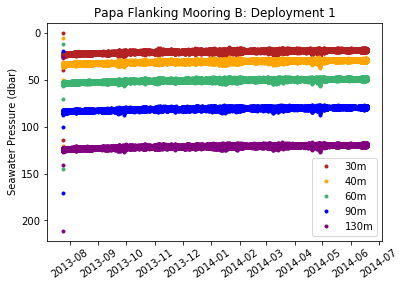

In [9]:
# Plot the pressure data to make sure you have the CTDs you were expecting
fig, ax = plt.subplots()
plt.plot(CTD30_data['time'], CTD30_data['ctdmo_seawater_pressure'], color='firebrick', marker='.', linestyle='None', label='30m')
plt.plot(CTD40_data['time'], CTD40_data['ctdmo_seawater_pressure'], color='orange', marker='.', linestyle='None', label='40m')
plt.plot(CTD60_data['time'], CTD60_data['ctdmo_seawater_pressure'], color='mediumseagreen', marker='.', linestyle='None', label='60m')
plt.plot(CTD90_data['time'], CTD90_data['ctdmo_seawater_pressure'], color='blue', marker='.', linestyle='None', label='90m')
plt.plot(CTD130_data['time'], CTD130_data['ctdmo_seawater_pressure'], color='purple', marker='.', linestyle='None', label='130m')
ax.legend()
ax.invert_yaxis()
ax.set_xlabel('')
ax.set_ylabel('Seawater Pressure ({})'.format(CTD30_units['ctdmo_seawater_pressure'][0]))
ax.set_title('Papa Flanking Mooring B: Deployment 1')
plt.xticks(rotation=35);

There are a few outliers scattered throughout these datasets, usually concentrated near the deployment start/end times. Because these moorings are in very deep waters, it can take several hours for the mooring to completely settle and those data points are most likely captured as the instruments are sinking to their final deployment depth. Similarly, at recovery some data points can be captured as the instruments rise in the water column.

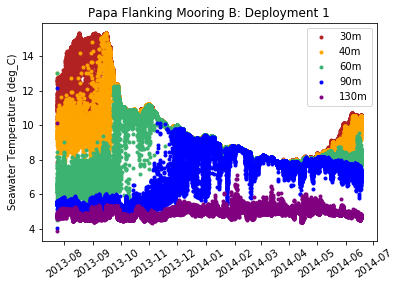

In [10]:
# Make a quick plot of temperature
fig, ax = plt.subplots()
plt.plot(CTD30_data['time'], CTD30_data['ctdmo_seawater_temperature'], color='firebrick', marker='.', linestyle='None', label='30m')
plt.plot(CTD40_data['time'], CTD40_data['ctdmo_seawater_temperature'], color='orange', marker='.', linestyle='None', label='40m')
plt.plot(CTD60_data['time'], CTD60_data['ctdmo_seawater_temperature'], color='mediumseagreen', marker='.', linestyle='None', label='60m')
plt.plot(CTD90_data['time'], CTD90_data['ctdmo_seawater_temperature'], color='blue', marker='.', linestyle='None', label='90m')
plt.plot(CTD130_data['time'], CTD130_data['ctdmo_seawater_temperature'], color='purple', marker='.', linestyle='None', label='130m')
ax.legend()
ax.set_xlabel('')
ax.set_ylabel('Seawater Temperature (deg_C)')
ax.set_title('Papa Flanking Mooring B: Deployment 1')
plt.xticks(rotation=35);

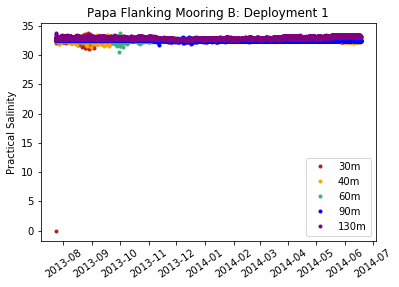

In [11]:
# ...and salinity - the outliers here at the beginning of each deployment are very obvious
fig, ax = plt.subplots()
plt.plot(CTD30_data['time'], CTD30_data['practical_salinity'], color='firebrick', marker='.', linestyle='None', label='30m')
plt.plot(CTD40_data['time'], CTD40_data['practical_salinity'], color='orange', marker='.', linestyle='None', label='40m')
plt.plot(CTD60_data['time'], CTD60_data['practical_salinity'], color='mediumseagreen', marker='.', linestyle='None', label='60m')
plt.plot(CTD90_data['time'], CTD90_data['practical_salinity'], color='blue', marker='.', linestyle='None', label='90m')
plt.plot(CTD130_data['time'], CTD130_data['practical_salinity'], color='purple', marker='.', linestyle='None', label='130m')
ax.legend()
ax.set_xlabel('')
ax.set_ylabel('Practical Salinity')
ax.set_title('Papa Flanking Mooring B: Deployment 1')
plt.xticks(rotation=35);

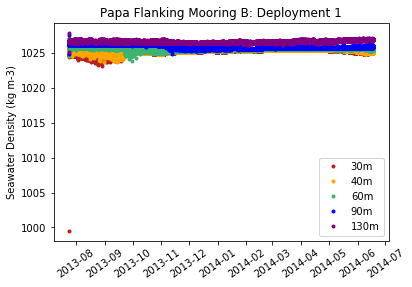

In [12]:
# ...and density - again, the outliers are very obvious
fig, ax = plt.subplots()
plt.plot(CTD30_data['time'], CTD30_data['density'], color='firebrick', marker='.', linestyle='None', label='30m')
plt.plot(CTD40_data['time'], CTD40_data['density'], color='orange', marker='.', linestyle='None', label='40m')
plt.plot(CTD60_data['time'], CTD60_data['density'], color='mediumseagreen', marker='.', linestyle='None', label='60m')
plt.plot(CTD90_data['time'], CTD90_data['density'], color='blue', marker='.', linestyle='None', label='90m')
plt.plot(CTD130_data['time'], CTD130_data['density'], color='purple', marker='.', linestyle='None', label='130m')
ax.legend()
ax.set_xlabel('')
ax.set_ylabel('Seawater Density ({})'.format(CTD30_units['density'][0]))
ax.set_title('Papa Flanking Mooring B: Deployment 1')
plt.xticks(rotation=35);

We'll want to remove those outliers before calculating hourly averages (to make the csv files more manageable). Here's a function to remove the outliers from the dataframe (it removes the entire row of data if one variable is an outlier).

In [13]:
def remove_outliers(df, variables, m):
    cnames = []
    for v in variables:
        mn = np.nanmean(df[v])
        std = np.nanstd(df[v])
        cname = v + '_ind'
        cnames.append(cname)
        df[cname] = abs(df[v] - mn) < m * std
    for cn in cnames:
        df = df.loc[df[cn] == True]
    df = df.drop(columns=cnames)
    return df

Specify the # of standard deviations from the mean you want to remove. In this example we'll remove any data points that are more than 5 standard deviations from the mean.

In [14]:
std_from_mean = 5
CTD30_data_clean = remove_outliers(CTD30_data, ctd_variables, std_from_mean)
CTD40_data_clean = remove_outliers(CTD40_data, ctd_variables, std_from_mean)
CTD60_data_clean = remove_outliers(CTD60_data, ctd_variables, std_from_mean)
CTD90_data_clean = remove_outliers(CTD90_data, ctd_variables, std_from_mean)
CTD130_data_clean = remove_outliers(CTD130_data, ctd_variables, std_from_mean)

Plot the salinity and density data again to make sure you removed all of the outliers

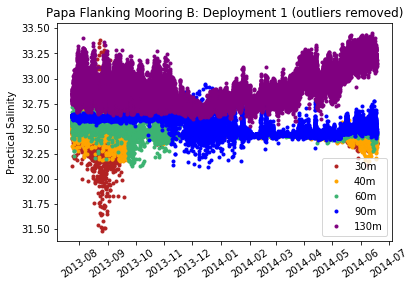

In [15]:
fig, ax = plt.subplots()
plt.plot(CTD30_data_clean['time'], CTD30_data_clean['practical_salinity'], color='firebrick', marker='.', linestyle='None', label='30m')
plt.plot(CTD40_data_clean['time'], CTD40_data_clean['practical_salinity'], color='orange', marker='.', linestyle='None', label='40m')
plt.plot(CTD60_data_clean['time'], CTD60_data_clean['practical_salinity'], color='mediumseagreen', marker='.', linestyle='None', label='60m')
plt.plot(CTD90_data_clean['time'], CTD90_data_clean['practical_salinity'], color='blue', marker='.', linestyle='None', label='90m')
plt.plot(CTD130_data_clean['time'], CTD130_data_clean['practical_salinity'], color='purple', marker='.', linestyle='None', label='130m')
ax.legend()
ax.set_xlabel('')
ax.set_ylabel('Practical Salinity')
ax.set_title('Papa Flanking Mooring B: Deployment 1 (outliers removed)')
plt.xticks(rotation=35);

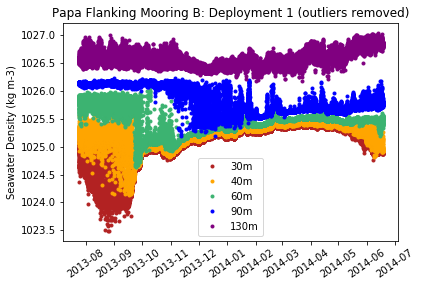

In [16]:
fig, ax = plt.subplots()
plt.plot(CTD30_data_clean['time'], CTD30_data_clean['density'], color='firebrick', marker='.', linestyle='None', label='30m')
plt.plot(CTD40_data_clean['time'], CTD40_data_clean['density'], color='orange', marker='.', linestyle='None', label='40m')
plt.plot(CTD60_data_clean['time'], CTD60_data_clean['density'], color='mediumseagreen', marker='.', linestyle='None', label='60m')
plt.plot(CTD90_data_clean['time'], CTD90_data_clean['density'], color='blue', marker='.', linestyle='None', label='90m')
plt.plot(CTD130_data_clean['time'], CTD130_data_clean['density'], color='purple', marker='.', linestyle='None', label='130m')
ax.legend()
ax.set_xlabel('')
ax.set_ylabel('Seawater Density ({})'.format(CTD30_units['density'][0]))
ax.set_title('Papa Flanking Mooring B: Deployment 1 (outliers removed)')
plt.xticks(rotation=35);

## 3. Merge and export

Now that the datasets have been cleaned up a bit, we can calculate hourly averages to make the dataset more manageable, merge the datasets, and export as a .csv file.

In [17]:
# rename and add units to the columns
CTD30_data_clean = CTD30_data_clean.rename(columns={'ctdmo_seawater_pressure': 'CTD30m Pressure ({})'.format(CTD30_units['ctdmo_seawater_pressure'][0]),
                                                     'ctdmo_seawater_temperature': 'CTD30m Temp (deg_C)',
                                                     'practical_salinity': 'CTD30m Salinity',
                                                     'density': 'CTD30m Density ({})'.format(CTD30_units['density'][0])})

CTD40_data_clean = CTD40_data_clean.rename(columns={'ctdmo_seawater_pressure': 'CTD40m Pressure ({})'.format(CTD40_units['ctdmo_seawater_pressure'][0]),
                                                     'ctdmo_seawater_temperature': 'CTD40m Temp (deg_C)',
                                                     'practical_salinity': 'CTD40m Salinity',
                                                     'density': 'CTD40m Density ({})'.format(CTD40_units['density'][0])})

CTD60_data_clean = CTD60_data_clean.rename(columns={'ctdmo_seawater_pressure': 'CTD60m Pressure ({})'.format(CTD60_units['ctdmo_seawater_pressure'][0]),
                                                     'ctdmo_seawater_temperature': 'CTD60m Temp (deg_C)',
                                                     'practical_salinity': 'CTD60m Salinity',
                                                     'density': 'CTD60m Density ({})'.format(CTD60_units['density'][0])})

CTD90_data_clean = CTD90_data_clean.rename(columns={'ctdmo_seawater_pressure': 'CTD90m Pressure ({})'.format(CTD90_units['ctdmo_seawater_pressure'][0]),
                                                     'ctdmo_seawater_temperature': 'CTD90m Temp (deg_C)',
                                                     'practical_salinity': 'CTD90m Salinity',
                                                     'density': 'CTD90m Density ({})'.format(CTD90_units['density'][0])})

CTD130_data_clean = CTD130_data_clean.rename(columns={'ctdmo_seawater_pressure': 'CTD130m Pressure ({})'.format(CTD130_units['ctdmo_seawater_pressure'][0]),
                                                     'ctdmo_seawater_temperature': 'CTD130m Temp (deg_C)',
                                                     'practical_salinity': 'CTD130m Salinity',
                                                     'density': 'CTD130m Density ({})'.format(CTD130_units['density'][0])})

# print the first few lines of the 30m dataset
CTD30_data_clean.head()

,time,CTD30m Pressure (dbar),CTD30m Temp (deg_C),CTD30m Salinity,CTD30m Density (kg m-3)
3,2013-07-24 07:30:01,26.366162,10.097817,32.451193,1025.070567
4,2013-07-24 07:45:01,23.851939,10.337427,32.504927,1025.060883
5,2013-07-24 08:00:01,24.066116,10.519235,32.532808,1025.052596
6,2013-07-24 08:15:01,23.913527,10.899614,32.399220,1024.882040
7,2013-07-24 08:30:01,24.249097,10.855261,32.478856,1024.953272


In [18]:
# calculate hourly averages for each dataframe
CTD30_hourly = CTD30_data_clean.resample('H', on='time').mean().dropna(how='all').reset_index()
CTD40_hourly = CTD40_data_clean.resample('H', on='time').mean().dropna(how='all').reset_index()
CTD60_hourly = CTD60_data_clean.resample('H', on='time').mean().dropna(how='all').reset_index()
CTD90_hourly = CTD90_data_clean.resample('H', on='time').mean().dropna(how='all').reset_index()
CTD130_hourly = CTD130_data_clean.resample('H', on='time').mean().dropna(how='all').reset_index()

# print the first few lines of the 30m dataset
CTD30_hourly.head()

,time,CTD30m Pressure (dbar),CTD30m Temp (deg_C),CTD30m Salinity,CTD30m Density (kg m-3)
0,2013-07-24 07:00:00,25.109050,10.217622,32.478060,1025.065725
1,2013-07-24 08:00:00,24.175401,10.978655,32.496717,1024.944329
2,2013-07-24 09:00:00,24.762512,11.352293,32.508642,1024.890024
3,2013-07-24 10:00:00,24.353607,12.545807,32.402349,1024.584696
4,2013-07-24 11:00:00,24.556274,11.966799,32.531814,1024.794367


In [19]:
# merge the dataframes
merge1 = pd.merge(CTD30_hourly, CTD40_hourly, on='time', how='outer')
merge2 = pd.merge(merge1, CTD60_hourly, on='time', how='outer')
merge3 = pd.merge(merge2, CTD90_hourly, on='time', how='outer')
merged = pd.merge(merge3, CTD130_hourly, on='time', how='outer')
merged = merged.sort_values('time').reset_index(drop=True)  # make sure the dataframe is sorted by time
merged.head()

,time,CTD30m Pressure (dbar),CTD30m Temp (deg_C),CTD30m Salinity,CTD30m Density (kg m-3),CTD40m Pressure (dbar),CTD40m Temp (deg_C),CTD40m Salinity,CTD40m Density (kg m-3),CTD60m Pressure (dbar),...,CTD60m Salinity,CTD60m Density (kg m-3),CTD90m Pressure (dbar),CTD90m Temp (deg_C),CTD90m Salinity,CTD90m Density (kg m-3),CTD130m Pressure (dbar),CTD130m Temp (deg_C),CTD130m Salinity,CTD130m Density (kg m-3)
0,2013-07-24 07:00:00,25.109050,10.217622,32.478060,1025.065725,35.921736,9.082999,32.501853,1025.317614,55.761787,...,32.604606,1025.917429,86.201802,5.386896,32.623537,1026.151482,126.375114,4.740252,32.843387,1026.586730
1,2013-07-24 08:00:00,24.175401,10.978655,32.496717,1024.944329,35.169583,9.509111,32.530805,1025.268885,54.837926,...,32.546596,1025.829695,85.471188,5.502492,32.625755,1026.136221,125.637794,4.880220,32.761935,1026.503116
2,2013-07-24 09:00:00,24.762512,11.352293,32.508642,1024.890024,35.575335,9.869185,32.521379,1025.204982,55.433543,...,32.634325,1025.791894,85.874770,5.540463,32.624342,1026.132505,126.070525,4.743959,32.782104,1026.536337
3,2013-07-24 10:00:00,24.353607,12.545807,32.402349,1024.584696,35.505342,10.298171,32.519704,1025.131555,55.053434,...,32.550171,1025.609258,85.777194,5.560467,32.628050,1026.132586,125.934070,4.736941,32.802771,1026.552847
4,2013-07-24 11:00:00,24.556274,11.966799,32.531814,1024.794367,34.811171,10.223086,32.490058,1025.117914,55.174633,...,32.550274,1025.664625,85.172388,5.470328,32.626986,1026.139626,125.384382,4.694789,32.842861,1026.586699


Now that we have our hourly-averaged, merged dataframe, let's plot the variables to make sure it looks reasonable.

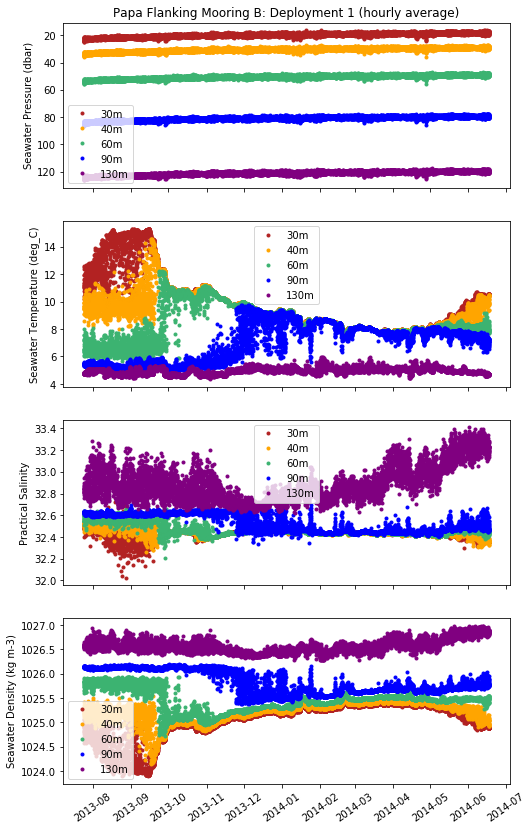

In [20]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, sharex=True, figsize = (8,14))
ax1.plot(merged['time'], merged['CTD30m Pressure (dbar)'], color='firebrick', marker='.', linestyle='None', label='30m')
ax1.plot(merged['time'], merged['CTD40m Pressure (dbar)'], color='orange', marker='.', linestyle='None', label='40m')
ax1.plot(merged['time'], merged['CTD60m Pressure (dbar)'], color='mediumseagreen', marker='.', linestyle='None', label='60m')
ax1.plot(merged['time'], merged['CTD90m Pressure (dbar)'], color='blue', marker='.', linestyle='None', label='90m')
ax1.plot(merged['time'], merged['CTD130m Pressure (dbar)'], color='purple', marker='.', linestyle='None', label='130m')
ax1.invert_yaxis()
ax1.legend()
ax1.set_xlabel('')
ax1.set_ylabel('Seawater Pressure (dbar)')
ax1.set_title('Papa Flanking Mooring B: Deployment 1 (hourly average)')

ax2.plot(merged['time'], merged['CTD30m Temp (deg_C)'], color='firebrick', marker='.', linestyle='None', label='30m')
ax2.plot(merged['time'], merged['CTD40m Temp (deg_C)'], color='orange', marker='.', linestyle='None', label='40m')
ax2.plot(merged['time'], merged['CTD60m Temp (deg_C)'], color='mediumseagreen', marker='.', linestyle='None', label='60m')
ax2.plot(merged['time'], merged['CTD90m Temp (deg_C)'], color='blue', marker='.', linestyle='None', label='90m')
ax2.plot(merged['time'], merged['CTD130m Temp (deg_C)'], color='purple', marker='.', linestyle='None', label='130m')
ax2.legend()
ax2.set_xlabel('')
ax2.set_ylabel('Seawater Temperature (deg_C)')

ax3.plot(merged['time'], merged['CTD30m Salinity'], color='firebrick', marker='.', linestyle='None', label='30m')
ax3.plot(merged['time'], merged['CTD40m Salinity'], color='orange', marker='.', linestyle='None', label='40m')
ax3.plot(merged['time'], merged['CTD60m Salinity'], color='mediumseagreen', marker='.', linestyle='None', label='60m')
ax3.plot(merged['time'], merged['CTD90m Salinity'], color='blue', marker='.', linestyle='None', label='90m')
ax3.plot(merged['time'], merged['CTD130m Salinity'], color='purple', marker='.', linestyle='None', label='130m')
ax3.legend()
ax3.set_xlabel('')
ax3.set_ylabel('Practical Salinity')

ax4.plot(merged['time'], merged['CTD30m Density (kg m-3)'], color='firebrick', marker='.', linestyle='None', label='30m')
ax4.plot(merged['time'], merged['CTD40m Density (kg m-3)'], color='orange', marker='.', linestyle='None', label='40m')
ax4.plot(merged['time'], merged['CTD60m Density (kg m-3)'], color='mediumseagreen', marker='.', linestyle='None', label='60m')
ax4.plot(merged['time'], merged['CTD90m Density (kg m-3)'], color='blue', marker='.', linestyle='None', label='90m')
ax4.plot(merged['time'], merged['CTD130m Density (kg m-3)'], color='purple', marker='.', linestyle='None', label='130m')
ax4.legend()
ax4.set_xlabel('')
ax4.set_ylabel('Seawater Density (kg m-3)')
plt.xticks(rotation=35);

In [21]:
# Looks good! Now let's add the chlorophyll data
FLORT_data.head()

,time,fluorometric_chlorophyll_a
0,2013-07-24 06:45:01,0.1936
1,2013-07-24 07:00:01,0.0000
2,2013-07-24 07:15:01,1.0285
3,2013-07-24 07:30:01,0.6776
4,2013-07-24 07:45:01,0.7018


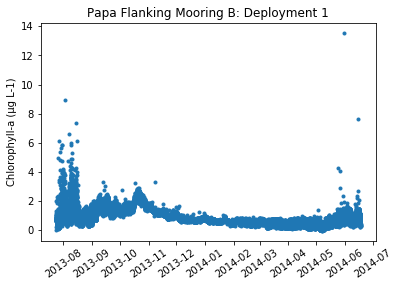

In [22]:
# make a quick plot
fig, ax = plt.subplots()
plt.plot(FLORT_data['time'], FLORT_data['fluorometric_chlorophyll_a'], '.')
ax.set_xlabel('')
ax.set_ylabel('Chlorophyll-a ({})'.format(FLORT_units['fluorometric_chlorophyll_a'][0]))
ax.set_title('Papa Flanking Mooring B: Deployment 1')
plt.xticks(rotation=35);

In [23]:
# calculate hourly averages
FLORT_hourly = FLORT_data.resample('H', on='time').mean().dropna(how='all').reset_index()
FLORT_hourly.head()

,time,fluorometric_chlorophyll_a
0,2013-07-24 06:00:00,0.193600
1,2013-07-24 07:00:00,0.601975
2,2013-07-24 08:00:00,0.738100
3,2013-07-24 09:00:00,0.780450
4,2013-07-24 10:00:00,1.061775


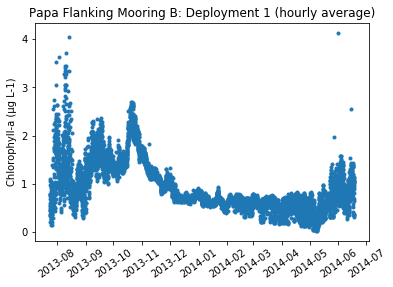

In [24]:
# plot hourly averaged data
fig, ax = plt.subplots()
plt.plot(FLORT_hourly['time'], FLORT_hourly['fluorometric_chlorophyll_a'], '.')
ax.set_xlabel('')
ax.set_ylabel('Chlorophyll-a ({})'.format(FLORT_units['fluorometric_chlorophyll_a'][0]))
ax.set_title('Papa Flanking Mooring B: Deployment 1 (hourly average)')
plt.xticks(rotation=35);

In [25]:
# merge the chlorophyll-a data with the larger dataframe
merged_all = pd.merge(merged, FLORT_hourly, on='time', how='outer')
merged_all = merged_all.sort_values('time').reset_index(drop=True)  # make sure the dataframe is sorted by time

# rename the chlorophyll-a column
merged_all = merged_all.rename(columns={'fluorometric_chlorophyll_a': 'Chlorophyll-a 30m ({})'.format(FLORT_units['fluorometric_chlorophyll_a'][0])})
merged_all.head()

,time,CTD30m Pressure (dbar),CTD30m Temp (deg_C),CTD30m Salinity,CTD30m Density (kg m-3),CTD40m Pressure (dbar),CTD40m Temp (deg_C),CTD40m Salinity,CTD40m Density (kg m-3),CTD60m Pressure (dbar),...,CTD60m Density (kg m-3),CTD90m Pressure (dbar),CTD90m Temp (deg_C),CTD90m Salinity,CTD90m Density (kg m-3),CTD130m Pressure (dbar),CTD130m Temp (deg_C),CTD130m Salinity,CTD130m Density (kg m-3),Chlorophyll-a 30m (µg L-1)
0,2013-07-24 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.193600
1,2013-07-24 07:00:00,25.109050,10.217622,32.478060,1025.065725,35.921736,9.082999,32.501853,1025.317614,55.761787,...,1025.917429,86.201802,5.386896,32.623537,1026.151482,126.375114,4.740252,32.843387,1026.586730,0.601975
2,2013-07-24 08:00:00,24.175401,10.978655,32.496717,1024.944329,35.169583,9.509111,32.530805,1025.268885,54.837926,...,1025.829695,85.471188,5.502492,32.625755,1026.136221,125.637794,4.880220,32.761935,1026.503116,0.738100
3,2013-07-24 09:00:00,24.762512,11.352293,32.508642,1024.890024,35.575335,9.869185,32.521379,1025.204982,55.433543,...,1025.791894,85.874770,5.540463,32.624342,1026.132505,126.070525,4.743959,32.782104,1026.536337,0.780450
4,2013-07-24 10:00:00,24.353607,12.545807,32.402349,1024.584696,35.505342,10.298171,32.519704,1025.131555,55.053434,...,1025.609258,85.777194,5.560467,32.628050,1026.132586,125.934070,4.736941,32.802771,1026.552847,1.061775


In [26]:
# export as .csv
merged_all.to_csv(os.path.join(save_dir, 'Theme2a_Papa_MLD.csv'), index=False)